In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled)


In [2]:
# Seed for reproducibility
np.random.seed(42)

In [3]:
# Download the MNIST digits dataset
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2015-11-08 15:37:00--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Server file no newer than local file ‘mnist.pkl.gz’ -- not retrieving.



In [4]:
# Load training and test splits as numpy arrays
train, val, test = pickle.load(gzip.open('mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [5]:
# The original 28x28 pixel images are flattened into 784 dimensional feature vectors
X_train.shape

(50000, 784)

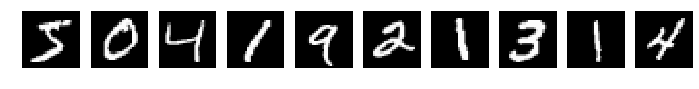

In [6]:
# Plot the first few examples 
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [7]:
# For training, we want to sample examples at random in small batches
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [8]:
# A very simple network, a single layer with one neuron per target class.
# Using the softmax activation function gives us a probability distribution at the output.
l_in = lasagne.layers.InputLayer((None, 784))
l_out = lasagne.layers.DenseLayer(
    l_in,
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

In [9]:
# Symbolic variables for our input features and targets
X_sym = T.matrix()
y_sym = T.ivector()

In [10]:
# Theano expressions for the output distribution and predicted class
output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

In [11]:
# The loss function is cross-entropy averaged over a minibatch, we also compute accuracy as an evaluation metric
loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))
acc = T.mean(T.eq(pred, y_sym))

In [12]:
# We retrieve all the trainable parameters in our network - a single weight matrix and bias vector
params = lasagne.layers.get_all_params(l_out)
print(params)

[W, b]


In [13]:
# Compute the gradient of the loss function with respect to the parameters.
# The stochastic gradient descent algorithm produces updates for each param
grad = T.grad(loss, params)
updates = lasagne.updates.sgd(grad, params, learning_rate=0.05)
print(updates)

OrderedDict([(W, Elemwise{sub,no_inplace}.0), (b, Elemwise{sub,no_inplace}.0)])


In [14]:
# We define a training function that will compute the loss and accuracy, and take a single optimization step
f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)

In [15]:
# The validation function is similar, but does not update the parameters
f_val = theano.function([X_sym, y_sym], [loss, acc])

In [16]:
# The prediction function doesn't require targets, and outputs only the predicted class values
f_predict = theano.function([X_sym], pred)

In [17]:
# We'll choose a batch size, and calculate the number of batches in an "epoch"
# (approximately one pass through the data).
BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

In [18]:
# Minibatch generators for the training and validation sets
train_batches = batch_gen(X_train, y_train, BATCH_SIZE)
val_batches = batch_gen(X_val, y_val, BATCH_SIZE)

5


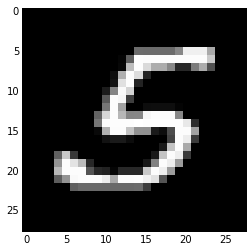

In [19]:
# Try sampling from the batch generator.
# Plot an image and corresponding label to verify they match.
X, y = next(train_batches)
plt.imshow(X[0].reshape((28, 28)), cmap='gray', interpolation='nearest')
print(y[0])

In [20]:
# For each epoch, we call the training function N_BATCHES times,
# accumulating an estimate of the training loss and accuracy.
# Then we do the same thing for the validation set.
# Plotting the ratio of val to train loss can help recognize overfitting.
for epoch in range(10):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch 0, Train (val) loss 0.621 (0.379) ratio 0.610
Train (val) accuracy 0.844 (0.900)
Epoch 1, Train (val) loss 0.389 (0.346) ratio 0.890
Train (val) accuracy 0.895 (0.907)
Epoch 2, Train (val) loss 0.356 (0.320) ratio 0.901
Train (val) accuracy 0.900 (0.913)
Epoch 3, Train (val) loss 0.340 (0.303) ratio 0.893
Train (val) accuracy 0.904 (0.913)
Epoch 4, Train (val) loss 0.329 (0.299) ratio 0.909
Train (val) accuracy 0.909 (0.916)
Epoch 5, Train (val) loss 0.320 (0.299) ratio 0.935
Train (val) accuracy 0.911 (0.919)
Epoch 6, Train (val) loss 0.308 (0.286) ratio 0.929
Train (val) accuracy 0.914 (0.919)
Epoch 7, Train (val) loss 0.307 (0.302) ratio 0.985
Train (val) accuracy 0.914 (0.918)
Epoch 8, Train (val) loss 0.304 (0.286) ratio 0.941
Train (val) accuracy 0.915 (0.921)
Epoch 9, Train (val) loss 0.299 (0.281) ratio 0.940
Train (val) accuracy 0.917 (0.922)


In [21]:
# We can retrieve the value of the trained weight matrix from the output layer.
# It can be interpreted as a collection of images, one per class
weights = l_out.W.get_value()
print(weights.shape)

(784, 10)


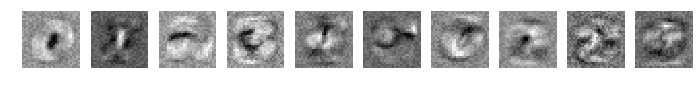

In [22]:
# Plotting the weight images, we can recognize similarities to the target images
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(weights[:,i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

Exercises
=====

1. Logistic regression
----------------------

The simple network we created is similar to a logistic regression model. Verify that the accuracy is close to that of `sklearn.linear_model.LogisticRegression`.

In [23]:
# Uncomment and execute this cell for an example solution
#%load spoilers/logreg.py

2. Hidden layer
---------------

Try adding one or more "hidden" `DenseLayers` between the input and output. Experiment with different numbers of hidden units.

In [24]:
# Uncomment and execute this cell for an example solution
#%load spoilers/hiddenlayer.py

3. Optimizer
------------

Try one of the other algorithms available in `lasagne.updates`. You may also want to adjust the learning rate.
Visualize and compare the trained weights. Different optimization trajectories may lead to very different results, even if the performance is similar. This can be important when training more complicated networks.

In [25]:
# Uncomment and execute this cell for an example solution
# %load spoilers/optimizer.py